## Modeling - artificial dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
# from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, make_scorer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import loguniform, uniform, randint

sns.set_style('whitegrid')
sns.set_palette('dark')

rs=123

In [2]:
# evaluation metric
def evaluation_metric(y_true, y_pred, m):
    """
    Balanced accuracy calculation with penalty depending on the number of features.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ba = (1/2)*((tp/(tp+fn)) + (tn/(fp+tn)))
    penalty = 0.01*max(0, (1/5)*m - 1)
    return ba - penalty

### Data preparation

In [3]:
# loading data
x_train = pd.read_csv('./data/artificial_train.data', sep=" ", header=None)
x_test = pd.read_csv('./data/artificial_valid.data', sep=" ", header=None)
y_train = np.array(pd.read_csv('./data/artificial_train.labels', header=None)[0].tolist())

In [4]:
# dropping unnecessary NaN columns
x_train.drop(columns=x_train.columns[-1], axis=1, inplace=True)
x_test.drop(columns=x_test.columns[-1], axis=1, inplace=True)

In [5]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [6]:
# data size
print('Train: ' , x_train.shape)
print('Test: ', x_test.shape)

Train:  (2000, 500)
Test:  (600, 500)


-1    1000
 1    1000
dtype: int64


<AxesSubplot:ylabel='count'>

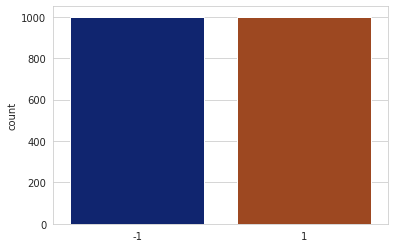

In [7]:
# target distribution
print(pd.Series(y_train).value_counts())
sns.countplot(y_train)

In [8]:
# train-valid split (stratification not needed - target perfectly balanced)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [9]:
# crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

In [10]:
# scaling - można spróbować innej metody i porównać
std = StandardScaler()
x_train_scaled = std.fit_transform(x_train)
x_valid_scaled = std.transform(x_valid)

### SelectKBest + Recursive Feature Elimination (RFE)

#### SelectKBest

In [11]:
k=100

In [12]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)

selector.fit(x_train_scaled, y_train)

SelectKBest(k=100, score_func=<function mutual_info_classif at 0x7f9d33f80940>)

In [13]:
x_train_kbest = selector.transform(x_train_scaled)

In [14]:
x_valid_kbest = selector.transform(x_valid_scaled)

#### Recursive Feature Elimination (RFE)

In [15]:
scores_ba = []
scores = []
n_of_features = np.arange(1,31,1)
for n in tqdm(n_of_features):
    clf = RandomForestClassifier(random_state=rs)
    rfe = RFE(clf, n_features_to_select=n)
    rfe.fit(x_train_kbest, y_train)
    x_train_rfe = rfe.transform(x_train_kbest)
    x_valid_rfe = rfe.transform(x_valid_kbest)
    rf = RandomForestClassifier(random_state=rs)
    rf.fit(x_train_rfe, y_train)
    y_pred = rf.predict(x_valid_rfe)
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, y_pred, x_valid_rfe.shape[1]))

100%|██████████| 30/30 [34:49<00:00, 69.65s/it]


In [16]:
results = pd.DataFrame([n_of_features, scores_ba, scores], 
                        index = ['No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/artificial_rfe_results.csv', index=False)

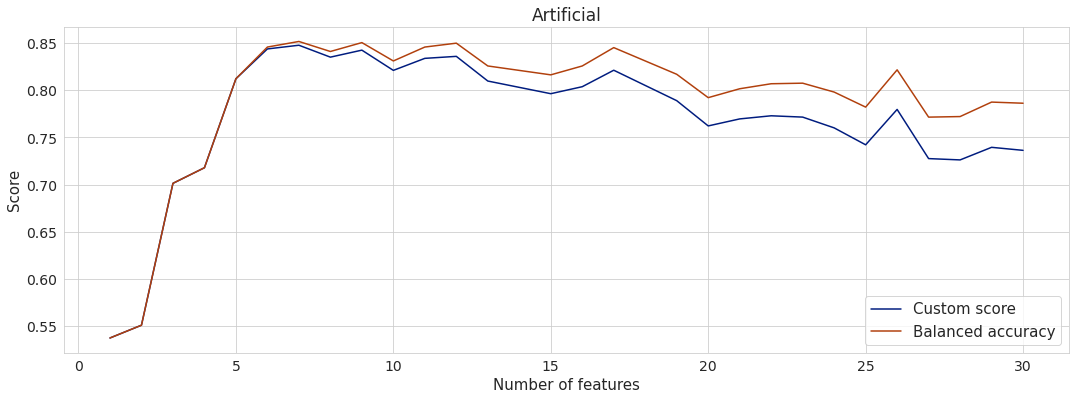

In [17]:
plt.figure(figsize=(18,6))
sns.lineplot(x=n_of_features, y=scores, label='Custom score') # niebieska
sns.lineplot(x=n_of_features, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Artificial', size=17)
plt.legend(fontsize=15)

In [18]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.84] 
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,6.000000,0.845950,0.843950
1,7.000000,0.851870,0.847870
2,9.000000,0.850660,0.842660


### SelectKBest + RFECV

#### Recursive Feature Elimination with cross-validation (RFECV)

In [19]:
clf = RandomForestClassifier(random_state=rs)

rfecv = RFECV(clf, step=1, cv=skf, scoring='balanced_accuracy')
# potrzebujemy jakos podać liczbe zmiennych wynikowych ale nie ma chyba jak tego zagnieździć :( 
# make_scorer(evaluation_metric, m=LICZBA ZMIENNYCH) (parametr evaluation metric, musi byc podany poza funkcja w tym przypadku)

rfecv = rfecv.fit(x_train_kbest, y_train)

In [20]:
x_train_rfecv = rfecv.transform(x_train_kbest)

In [21]:
x_valid_rfecv = rfecv.transform(x_valid_kbest)

In [22]:
x_valid_rfecv.shape[1]

10

In [23]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_rfecv, y_train)

RandomForestClassifier(random_state=123)

In [24]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_rfecv))

0.8311922922521076

In [25]:
evaluation_metric(y_valid, rf.predict(x_valid_rfecv), x_valid_rfecv.shape[1])

0.8211922922521075

### SelectKBest + Step Forward Feature Selection

#### Step Forward Feature Selection

In [26]:
clf = RandomForestClassifier(random_state=rs)
sfsf = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=True,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsf.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished

[2022-05-30 09:54:56] Features: 1/100 -- score: 0.5632158886994225[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  2.2min finished

[2022-05-30 09:57:06] Features: 2/100 -- score: 0.6476553703507233[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  2.0min finished

[2022-05-30 09:59:08] Features: 3/100 -- score: 0.7291594778985498[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          k_features='best', scoring='balanced_accuracy',
                          verbose=2)

In [27]:
x_train_sfsf = sfsf.transform(x_train_kbest)

In [28]:
x_valid_sfsf = sfsf.transform(x_valid_kbest)

In [29]:
x_valid_sfsf.shape[1]

10

In [30]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsf, y_train)

RandomForestClassifier(random_state=123)

In [31]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsf))

0.8412284223203532

In [32]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsf), x_valid_sfsf.shape[1])

0.8312284223203532

### SelectKBest + Step Backward Feature Selection

#### Step Backward Feature Selection

In [33]:
clf = RandomForestClassifier(random_state=rs)
sfsb = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=False,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsb.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.9min finished

[2022-05-30 13:30:52] Features: 99/1 -- score: 0.7424816026993893[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  6.4min finished

[2022-05-30 13:37:18] Features: 98/1 -- score: 0.734641436113097[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  6.4min finished

[2022-05-30 13:43:42] Features: 97/1 -- score: 0.7407277836248629[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          forward=False, k_features='best',
                          scoring='balanced_accuracy', verbose=2)

In [34]:
x_train_sfsb = sfsb.transform(x_train_kbest)

In [35]:
x_valid_sfsb = sfsb.transform(x_valid_kbest)

In [36]:
x_valid_sfsb.shape[1]

7

In [37]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsb, y_train)

RandomForestClassifier(random_state=123)

In [38]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsb))

0.8371136089923725

In [39]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsb), x_valid_sfsb.shape[1])

0.8331136089923725

### Boruta

In [40]:
max_depth = np.arange(2,16,1) #[2,3,4,5,6,7,8,9,10]
n_of_features = []
scores = []
scores_ba = []
for md in tqdm(max_depth):
    rf = RandomForestClassifier(class_weight='balanced', max_depth=md, random_state=rs) # z dokumentacji, można się pobawić moze coś zmieni
    rf.fit(x_train_scaled, y_train)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(np.array(x_train_scaled), y_train)    
    n_of_features.append(feat_selector.support_.sum())
    x_train_boruta = feat_selector.transform(np.array(x_train_scaled))
    x_valid_boruta = feat_selector.transform(np.array(x_valid_scaled))
    rf = RandomForestClassifier(random_state=rs) # moze próbowac grida zeby polepszyć
    rf.fit(x_train_boruta, y_train)
    scores_ba.append(balanced_accuracy_score(y_valid, rf.predict(x_valid_boruta)))
    scores.append(evaluation_metric(y_valid, rf.predict(x_valid_boruta), x_valid_boruta.shape[1]))

  0%|          | 0/14 [00:00<?, ?it/s]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	481
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	5
Rejected: 	481
Iteration: 	16 / 100
Confirmed: 	14
Tenta

  7%|▋         | 1/14 [02:36<33:50, 156.22s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	474
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	13
Rejected: 	474
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	13
Rejected: 	474
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	13
Rejected: 	474
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	10
Rejected: 	476
Iteration: 	16 / 100
Confirmed: 	1

 14%|█▍        | 2/14 [04:59<29:42, 148.54s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	478
Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478
Iteration: 	10 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478
Iteration: 	11 / 100
Confirmed: 	18
Tentative: 	4
Rejected: 	478
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 21%|██▏       | 3/14 [07:09<25:39, 139.93s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	476
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	4
Rejected: 	476
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 29%|██▊       | 4/14 [09:11<22:12, 133.21s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	478
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 36%|███▌      | 5/14 [11:11<19:12, 128.10s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	476
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	16 / 100
Confirmed: 	19
Tenta

 43%|████▎     | 6/14 [13:07<16:33, 124.20s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	471
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	471
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	471
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	9
Rejected: 	471
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 50%|█████     | 7/14 [15:02<14:08, 121.28s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	473
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	473
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	473
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	8
Rejected: 	473
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	3
Rejected: 	478
Iteration: 	16 / 100
Confirmed: 	19
Tenta

 57%|█████▋    | 8/14 [16:47<11:35, 115.89s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	474
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	7
Rejected: 	474
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	16 / 100
Confirmed: 	19
Tenta

 64%|██████▍   | 9/14 [18:26<09:13, 110.75s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	26
Rejected: 	474
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 71%|███████▏  | 10/14 [19:35<06:31, 97.75s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	22
Rejected: 	478
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	2
Rejected: 	478
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	1
Rejected: 	479
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	1
Rejected: 	479
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	1
Rejected: 	479
Iteration: 	16 / 100
Confirmed: 	20
Tenta

 79%|███████▊  | 11/14 [20:38<04:21, 87.07s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	475
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	6
Rejected: 	475
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	6
Rejected: 	475
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	6
Rejected: 	475
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	4
Rejected: 	477
Iteration: 	16 / 100
Confirmed: 	19
Tenta

 86%|████████▌ | 12/14 [22:07<02:55, 87.72s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	470
Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	11
Rejected: 	470
Iteration: 	10 / 100
Confirmed: 	19
Tentative: 	11
Rejected: 	470
Iteration: 	11 / 100
Confirmed: 	19
Tentative: 	11
Rejected: 	470
Iteration: 	12 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	13 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	14 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	15 / 100
Confirmed: 	19
Tentative: 	5
Rejected: 	476
Iteration: 	16 / 100
Confirmed: 	19
Te

 93%|█████████▎| 13/14 [23:36<01:28, 88.09s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	472
Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	8
Rejected: 	472
Iteration: 	10 / 100
Confirmed: 	20
Tentative: 	8
Rejected: 	472
Iteration: 	11 / 100
Confirmed: 	20
Tentative: 	8
Rejected: 	472
Iteration: 	12 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	13 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	14 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	15 / 100
Confirmed: 	20
Tentative: 	6
Rejected: 	474
Iteration: 	16 / 100
Confirmed: 	20
Tenta

100%|██████████| 14/14 [25:02<00:00, 107.32s/it]


In [41]:
results = pd.DataFrame([max_depth, n_of_features, scores_ba, scores], 
                        index = ['Max depth','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/artificial_boruta_results.csv', index=False)

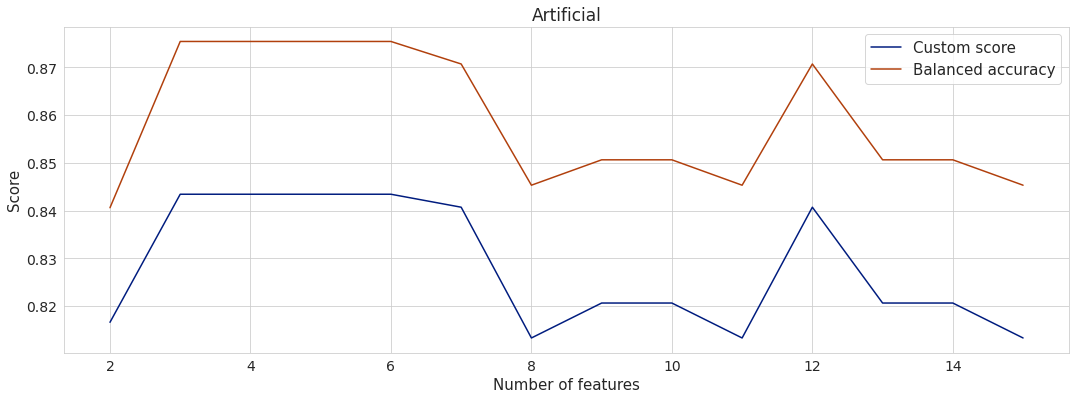

In [42]:
plt.figure(figsize=(18,6))
sns.lineplot(x=max_depth, y=scores, label='Custom score') # niebieska
sns.lineplot(x=max_depth, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Artificial', size=17)
plt.legend(fontsize=15)

In [43]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.84] # próg do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
max_depth_best = [int(elem) for i, elem in enumerate(max_depth) if i in ids_best]
best_results = pd.DataFrame([max_depth_best, n_of_features_best, scores_ba_best, scores_best], 
                            index = ['Max depth', 'No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,Max depth,No. of features,Balanced accuracy,Final score
0,7.000000,20.000000,0.870730,0.840730
1,12.000000,20.000000,0.870730,0.840730
2,3.000000,21.000000,0.875450,0.843450
3,4.000000,21.000000,0.875450,0.843450
4,5.000000,21.000000,0.875450,0.843450
5,6.000000,21.000000,0.875450,0.843450


### L1

In [44]:
scores = []
scores_ba = []
n_of_features = []
cs = np.arange(0.0015, 0.05, 0.0005)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(x_train_scaled, y_train), prefit=True)
    x_train_l1 = selector.transform(x_train_scaled)
    x_valid_l1 = selector.transform(x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(x_train_l1, y_train)
    y_pred = estimator.predict(x_valid_l1)
    n_of_features.append(x_train_l1.shape[1])
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, estimator.predict(x_valid_l1), x_valid_l1.shape[1]))

100%|██████████| 97/97 [03:16<00:00,  2.02s/it]


In [45]:
results = pd.DataFrame([cs, n_of_features, scores_ba, scores], 
                        index = ['C','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/artificial_l1_results.csv', index=False)

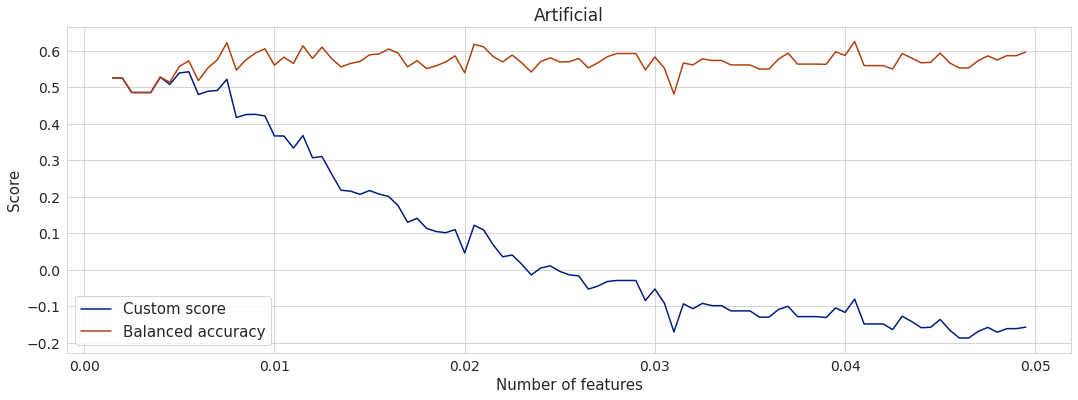

In [46]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores, label='Custom score') # niebieska
sns.lineplot(x=cs, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Artificial', size=17)
plt.legend(fontsize=15)

In [47]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.5] # ew. do zmiany
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,1.000000,0.525390,0.525390
1,1.000000,0.525390,0.525390
2,5.000000,0.527200,0.527200
3,8.000000,0.513650,0.507650
4,14.000000,0.556700,0.538700
5,20.000000,0.572060,0.542060
6,55.000000,0.621640,0.521640
